In [1]:
%matplotlib inline

import sys
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import math_ops
from ESN import EchoStateRNNCell
import matplotlib.pyplot as plt

In [2]:
# Configs ----------------------------------------------------------------------

# takes only current needed GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# random numbers
random_seed = None
rng = np.random.RandomState(random_seed)

Here we use tensorflow to implement a gradient descent optimization procedure for leaky echo-state networks. The procedure is taken from [jaeger, 2007](http://goo.gl/bqGAJu). with the difference that here we optimize only 
* **$\rho$** the spectral radius of the inner weights
* **$\tau$** the decay of the leaky
* **$s_w$** the scaling of the input weights
* **$\alpha$ a further parameter regulating the amount of rotation vs. expansion/contraction property of the dynamics defined by inner weight matrix of the network (see [ESN-definition.ipynb ](https://github.com/francesco-mannella/Echo-State-Networks/blob/master/ESN-definition.ipynb)).

In [3]:
# Utils ------------------------------------------------------------------------

def mult_sines(stime = 1200):
    res = np.arange(stime)
    res = np.sin(res) + np.sin(0.51*res) \
        + np.sin(0.22*res) \
        + np.sin(0.1002*res) \
        + np.sin(0.05343*res)
    
    res -= res.min() 
    res /= res.max()
    
    return res

def MSE(P, Y):
    return tf.reduce_mean(tf.pow(P - Y, 2)) 

def NRMSE(P, Y):
    return tf.sqrt(MSE(P, Y)) / (tf.reduce_max(Y) - tf.reduce_min(Y))


In [4]:
# Global variables --------------------------------------------------------------

batches = 1
stime = 700
num_units = 10
num_inputs = 1
# do the regression on a training subset of the timeseries
begin =  200
end = stime

# the activation function of the ESN
out_function = lambda x:  math_ops.tanh(x)


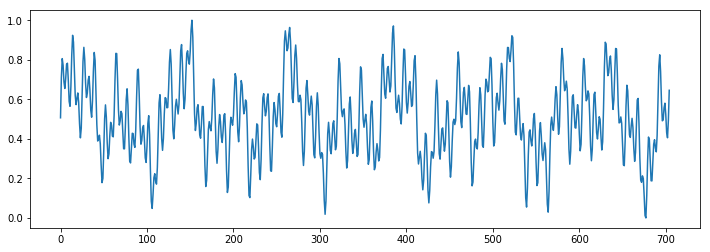

In [5]:
# input -------------------------------------------------------------------------
rnn_inputs = np.zeros((batches, stime, num_inputs), dtype="float32")
wave = mult_sines(stime+5).astype("float32")
rnn_inputs = wave[5:].reshape(1,stime, 1)
rnn_init_state = np.zeros([batches, num_units], dtype="float32")
plt.figure(figsize=(12,4))
wave_line, = plt.plot(wave)

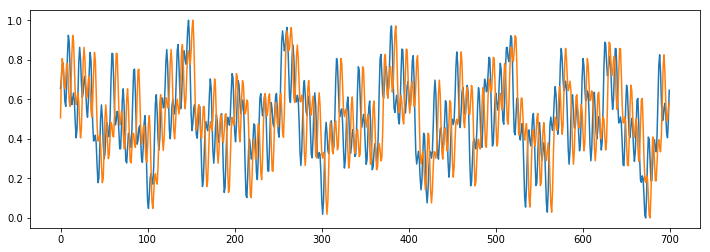

In [6]:
# the output target - mackey-glass ----------------------------------------------
rnn_target = wave[:-5]
rnn_target = rnn_target.reshape(stime, 1).astype("float32")
plt.figure(figsize=(12,4))
inp_line, = plt.plot(rnn_inputs[0,:,:])
targ_line, = plt.plot(rnn_target)


In [7]:
# tensorflow graph -------------------------------------------------------------

tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default() as g:
    
    rng = np.random.RandomState(random_seed)
    # gradient parameters
    lr = 0.1
    trials = 1000
    clipping_grads = False
    clipping_vars = True

    # Build the graph
    
    inputs = tf.placeholder(tf.float32, [batches, stime, num_inputs])
    target = tf.placeholder(tf.float32, [stime, 1])
    init_state = tf.placeholder(tf.float32, [1, num_units])

    # Init the ESN cell
    print "Making ESN init graph ..."
    cell = EchoStateRNNCell(num_units=num_units, 
                            activation=out_function, 
                            decay=0.1, 
                            alpha=0.5,
                            rng=rng, 
                            optimize=True,
                            optimize_vars=["rho", "alpha", "decay"])#,"decay", "sw"])
    print "Done"
    
    # cell spreading of activations
    print "Making ESN spreading graph ..."
    states = []
    state = init_state
    for t in range(stime):
        state,_ = cell(inputs=inputs[0,t:(t+1),:], state=state)
        states.append(state)
    outputs = tf.reshape(states, [stime, num_units])   
    print "Done"
    
    # ridge regression
    print "Making regression graph ..."
    # optimize also the lambda parameter of the ridge regression
    lmb = tf.get_variable("lmb", initializer=1e-10,  dtype=tf.float32, trainable=False)  
    X = outputs[begin:end,:]
    Y = target[begin:end,:] 
    cell.Wout = tf.matmul(tf.matrix_inverse(tf.matmul(tf.transpose(X), X) +
                lmb*tf.eye(num_units)), tf.matmul(tf.transpose(X), Y))
    print "Done"
    
    # compute readouts
    print "Making readout spreading graph ..."
    readouts = tf.matmul(outputs, cell.Wout)
    print "Done"
    
    # train graph
    print "Making training graph ..."    
    # calculate the loss over all the timeseries (escluded the beginning)
    loss = MSE(readouts[begin:end,:], target[begin:end,:]) 
        
    # optimize
        
    # init gradient descent
    optimizer = tf.train.GradientDescentOptimizer(lr)
        
    if clipping_grads == True:
            
        # get gradients
        grads_and_vars = optimizer.compute_gradients(
            loss, [cell.rho, cell.alpha, cell.decay, cell.sw, lmb])
            
        #clip gradients
        clipped_grads_and_vars = [
            (tf.clip_by_value(grad,-1.0, 1.0), var)
            for grad, var in grads_and_vars]
            
        # apply gradients
        train = optimizer.apply_gradients(clipped_grads_and_vars)
        
    elif clipping_grads == False:
            
        train = optimizer.minimize(loss)
        
    if clipping_vars == True:
        
        # clip parameters
        clipped_rho = tf.assign(cell.rho, tf.clip_by_value(cell.rho, 0.1, 1.0))
        clipped_alpha = tf.assign(cell.alpha, tf.clip_by_value(cell.alpha, 0.0, 1.0))
        clipped_decay = tf.assign(cell.decay, tf.clip_by_value(cell.decay, 0.01, 0.3))
        clipped_sw = tf.assign(cell.sw, tf.clip_by_value(cell.sw, 0.1, 10.0))
        clipped_lmb = tf.assign(lmb, tf.clip_by_value(lmb, 1.00e-10, 0.1))
        clip = tf.group(clipped_rho, clipped_alpha, clipped_decay, 
                        clipped_sw, clipped_lmb)
               
    print "Done"    

Making ESN init graph ...
Done
Making ESN spreading graph ...
Done
Making regression graph ...
Done
Making readout spreading graph ...
Done
Making training graph ...
Done


In [8]:
# run session -----------------------------------------------------------------
with graph.as_default() as g:

    with tf.Session(config=config) as session:
        
        session.run(tf.global_variables_initializer())
        losses = np.zeros(trials)
        
        print "Executing the graph"
        for k in range(trials):
             
            # run one timeseries using current parameters 
            # and update them 
            U, curr_outputs, curr_readouts, curr_loss, _ = \
                session.run([cell.U, outputs, readouts, loss, train], 
                             feed_dict={inputs:rnn_inputs,
                                       target: rnn_target,
                                       init_state:rnn_init_state})
            losses[k] = curr_loss

            # clip parameters after update
            if clipping_vars == True:
                session.run(clip)
            
            # read the current values of the parameters
            rho, alpha, decay, sw, curr_lmb = \
                session.run([cell.rho, cell.alpha,
                             cell.decay, cell.sw, lmb])

            # pront log of the parameters
            if k%50 == 0 or k == trials-1:
                sys.stdout.write("  step: {:4d}".format(k))
                sys.stdout.write(" NRMSE: {:6.4f}".format(curr_loss))
                sys.stdout.write("   rho: {:12.10f}".format(rho))
                sys.stdout.write(" alpha: {:6.4f}".format(alpha))
                sys.stdout.write(" decay: {:6.4f}".format(decay))
                sys.stdout.write("    sw: {:6.4f}".format(sw))
                sys.stdout.write("   lmb: {:6.4f}\n".format(curr_lmb))

        print "Done"


Executing the graph
  step:    0 NRMSE: 0.0356   rho: 0.5007377863 alpha: 0.5119 decay: 0.1047    sw: 1.0000   lmb: 0.0000
  step:   50 NRMSE: 0.0275   rho: 0.4883952737 alpha: 1.0000 decay: 0.2867    sw: 1.0000   lmb: 0.0000
  step:  100 NRMSE: 0.0363   rho: 0.2319846600 alpha: 1.0000 decay: 0.0518    sw: 1.0000   lmb: 0.0000
  step:  150 NRMSE: 0.0362   rho: 0.2336134166 alpha: 0.9999 decay: 0.0697    sw: 1.0000   lmb: 0.0000
  step:  200 NRMSE: 0.0362   rho: 0.2312614322 alpha: 0.9984 decay: 0.0752    sw: 1.0000   lmb: 0.0000
  step:  250 NRMSE: 0.0362   rho: 0.2302153111 alpha: 0.9983 decay: 0.0884    sw: 1.0000   lmb: 0.0000
  step:  300 NRMSE: 0.0361   rho: 0.2311661541 alpha: 1.0000 decay: 0.1118    sw: 1.0000   lmb: 0.0000
  step:  350 NRMSE: 0.0363   rho: 0.1584196389 alpha: 1.0000 decay: 0.0495    sw: 1.0000   lmb: 0.0000
  step:  400 NRMSE: 0.0363   rho: 0.1591742039 alpha: 0.9998 decay: 0.0610    sw: 1.0000   lmb: 0.0000
  step:  450 NRMSE: 0.0363   rho: 0.1582069099 alpha:

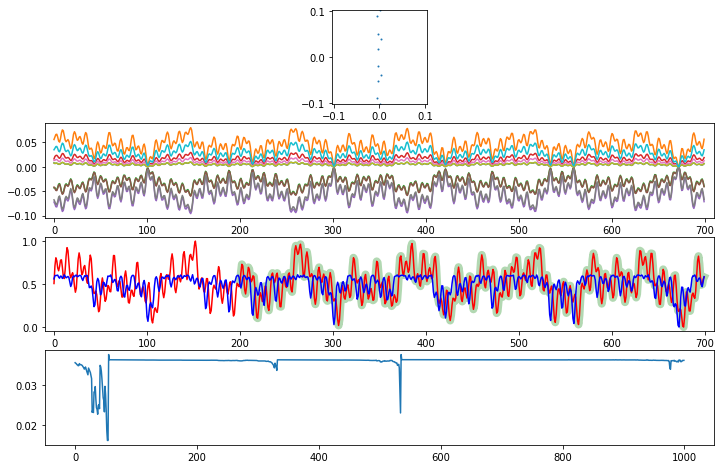

In [9]:
    # plot results ---------------------------------------------------------------
    
    plt.figure(figsize=(12,8))
    plt.subplot(411, aspect="equal")
    eigs = np.linalg.eigvals(U*rho)
    plt.scatter(eigs.real, eigs.imag, s=1)
    plt.xlim([-rho, rho])
    plt.ylim([-rho, rho])
    plt.subplot(412)
    plt.plot(curr_outputs)
    plt.xlim([-10, stime+10])
    plt.subplot(413)
    plt.plot(range(begin,end),rnn_target[begin:end,:], 
            color="green", lw=8, alpha=.3)
    plt.plot(rnn_target, color="red")
    plt.plot(curr_readouts, color="blue")
    plt.xlim([-10, stime+10])
    plt.subplot(414)
    plt.plot(losses)
    plt.show()
